# RCA Agent

The RCA agents take as input the affected resource, the symptom discovered by the triage agent and perform the Root Cause Analysis.

In [1]:
from dotenv import load_dotenv
import os
# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'), verbose=True)

True

In [2]:
import sys

# Add MCP-server to path
mcp_server_path = os.path.abspath(os.path.join(os.getcwd(), '../../MCP-server'))
sys.path.insert(0, mcp_server_path)

## MCP Server

List of available MCP servers:
- kubectl: provides an interface for the kubernetes cli
- cluster_api: custom MCP server developed to interact with the cluster and see dependencies, traces and metrics


In [3]:
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "cluster_api" : {
            "url": "http://localhost:8000/mcp",
            "transport": "streamable_http"
        }
    }
)

mcp_tools = await mcp_client.get_tools()

In [4]:
# Tools allowed
k8s_tools_allowed = ["kubectl_get", "kubectl_describe", "explain_resource", "list_api_resources", "ping"]
custom_tools_allowed = ["get_metrics", "get_metrics_range", "get_pods_from_service", "get_cluster_pods_and_services", "get_services_used_by", "get_dependencies", "get_logs", "get_traces", "get_trace"]

tools_allowed = k8s_tools_allowed + custom_tools_allowed

tools = []
for tool in mcp_tools:
    if tool.name in tools_allowed:
        tools.append(tool)

In [5]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.
🔧 get_metrics: Retrieve all instant Prometheus metrics for a specific Kubernetes pod or service. Returns comprehensive metrics including CPU, memory, network, and container specifications.
🔧 get_metrics_range: Retrieve historical Prometheus metrics for a specific Kubernetes pod or service over a time range.
🔧 get_pods_from_service: Retrieve all Kubernetes pods that belong to a specific service. Returns pod names and their current status (Running, Pending, etc.).
🔧 get_cluster_pods_and_services: Get a comprehensive overview of the Kubernetes cluster including all pods an

## Build the agent

In [6]:
from langchain_openai import ChatOpenAI

gpt5mini = ChatOpenAI(model="gpt-5-mini")

In [7]:
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Annotated
import operator


class Symptom(BaseModel):
    """
    A symptom observed in the Kubernetes cluster
    """
    potential_symptom: str = Field(..., description="Type of symptom observed")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource experiencing the issue")
    affected_resource: str = Field(..., description="Name of the resource experiencing the issue")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

In [8]:
from typing import List
from langgraph.graph.message import add_messages, AnyMessage


class RcaAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    symptom: Symptom
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    rca_analysis: dict

In [9]:
class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [10]:
rca_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with performing Root Cause Analysis (RCA) on a Kubernetes service.

    The service you are working with today is described below:
    {app_summary}

    A symptom has been detected in the cluster:
    - **Symptom Type**: {symptom_type}
    - **Affected Resource**: {resource_type} named '{affected_resource}'
    - **Evidence**: {evidence}

    You will use tools to investigate this symptom and identify the root cause.

    Available investigation approaches:
    - Use kubectl tools to inspect resource states, configurations, and events
    - Use observability tools (metrics, logs, traces) to analyze runtime behavior
    - Use get_dependencies or get_services_used_by to discover:
      * Infrastructure dependencies (databases, caches, message queues)
      * Service-to-service call chains (which services are called by a pod/service)

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Start your investigation from the symptom above - analyze the affected resource.
        2. Follow the evidence trail to identify the underlying root cause
        3. When you have identified the root cause, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the root cause you have identified (without proposing fixes)
            - reasoning: Explain your reasoning and thought process behind the diagnosis

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [11]:
summarise_prompt = """
    You are an autonomous SRE agent performing Root Cause Analysis on a Kubernetes incident.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages (tool call and response):
    {last_two_messages}

    Instructions:
    1. **Extract the key insight**: Identify the most important NEW finding from the tool response that helps diagnose the root cause. Focus on:
       - Anomalies or unusual patterns
       - Resource states that could cause issues
       - Dependencies or relationships discovered
       - Error messages or failure indicators
       If the tool call failed or returned no useful data, note this as the insight.
    
    2. **Describe the action taken**: Write a concise description of what tool was just called and what resource it examined.
       Format: "Checked [resource/metric] using [tool_name]"

    Keep both responses under 100 characters each. Be specific and actionable.
"""

In [12]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

In [13]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [14]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: RcaAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]} #type: ignore

In [15]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis (keep it concise)
    
    Returns:
        Command to update state and end workflow
    """
    final_response = {
        "diagnosis" : diagnosis,
        "reasoning" : reasoning
    }
    
    return Command(
        update={
            "rca_analysis": final_response,
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

In [16]:
# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [17]:
async def rcaAgent(state: RcaAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=rca_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"],
        symptom_type=state["symptom"].potential_symptom,
        resource_type=state["symptom"].resource_type,
        affected_resource=state["symptom"].affected_resource,
        evidence=state["symptom"].evidence
    ))

    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [18]:
from langchain_core.messages import AIMessage
from collections import Counter

def count_tool_calls(messages):
    """
    Plots a bar chart of tool call occurrences by tool name from state['messages'].
    """
    # Extract tool names from ToolMessage objects
    tool_calls = []
    for msg in messages:

        if isinstance(msg, AIMessage):
            if hasattr(msg, 'additional_kwargs'):
                if "tool_calls" in msg.additional_kwargs:
                    for call in msg.additional_kwargs['tool_calls']:
                        if "function" in call:
                            if "name" in call["function"]:
                                tool_calls.append(call["function"]["name"])

    # Count occurrences
    counts = Counter(tool_calls)

    return dict(counts)

In [19]:
async def format_response(state: RcaAgentState):

    final_report = state["rca_analysis"]
    
    final_report["symptom"] = {
        "potential_symptom" : state["symptom"].potential_symptom,
        "resource_type" : state["symptom"].resource_type,
        "affected_resource" : state["symptom"].affected_resource,
        "evidence" : state["symptom"].evidence
    }
    
    final_report["insights"] = state["insights"]
    final_report["steps_performed"] = state["prev_steps"]
    final_report["tools_stats"] = count_tool_calls(state["messages"])

    return {"rca_analysis" : final_report}

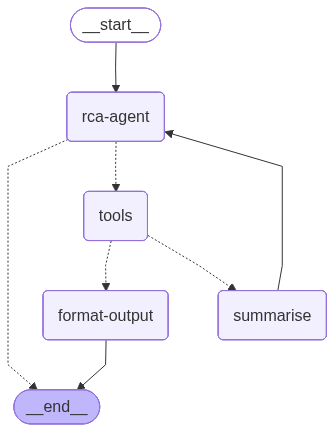

In [20]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(RcaAgentState)

# Add nodes
builder.add_node("rca-agent", rcaAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("format-output", format_response)

# Add edges
builder.add_edge(START, "rca-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "rca-agent",
    # Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: RcaAgentState):
    # If rca analysis is filled, investigation is complete (end of the workflow)
    if state.get("rca_analysis") and "diagnosis" in state["rca_analysis"] and "reasoning" in state["rca_analysis"]:
        return "format-output"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "format-output": "format-output"
    }
)

# After summarise, continue investigation (go to rca-agent)
builder.add_edge("summarise", "rca-agent")
builder.add_edge("format-output", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [21]:
import time

async def test_structured_graph(graph, app_summary:str, symptom: Symptom, human_message: str = "", trace_name: str | None = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "symptom" : symptom,
        "insights": [],
        "prev_steps": [],
        "rca_analysis" : {},
        "app_summary" : app_summary
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name # type: ignore
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return result

In [22]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "RCA agent"

In [23]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [24]:
symptom = Symptom(
    potential_symptom= "Container CrashLoopBackOff (restarting failure)",
    resource_type="pod",
    affected_resource="geo-6b4b89b5f5-wr9h2",
    evidence="Namespace=test-hotel-reservation, pod_phase=Running, container=hotel-reserv-geo, issue_type=Waiting, reason=CrashLoopBackOff, message='back-off 2m40s restarting failed container=hotel-reserv-geo pod=geo-6b4b89b5f5-wr9h2_test-hotel-reservation(...)', restart_count=5"
)

In [ ]:
human = ""
rca_agent_output = await test_structured_graph(structured_graph, app_summary, symptom, trace_name=experiment_name)

In [28]:
rca_agent_output["rca_analysis"]

{'diagnosis': 'The geo service container crashes because it cannot reach its MongoDB dependency: the geo app is configured to connect to mongodb-geo on port 27777, but the MongoDB pod/service is listening on port 27017. This port mismatch causes connection failures (panic: "no reachable servers") during startup, leading to repeated crashes and CrashLoopBackOff.',
 'reasoning': 'Evidence chain:\n- Pod geo-6b4b89b5f5-wr9h2 shows CrashLoopBackOff with RestartCount high and container exit code 2.\n- Application logs show panic: "no reachable servers" indicating DB unreachable at startup.\n- mongodb-geo pod (mongodb-geo-5ff578bcb8-r7vl6) is Running and its logs show it accepted connections (authenticated conn from 10.244.1.13), so MongoDB itself is healthy.\n- Endpoints for mongodb-geo list the pod at 10.244.1.14:27017 — MongoDB listens on 27017.\n- The geo application is observed to attempt connections to mongodb-geo:27777 (from previous investigation), which does not match the endpoint po